# 载入数据集

In [1]:
import cv2
import numpy as np
from tqdm import tqdm

n = 25000
width = 224

X = np.zeros((n, width, width, 3), dtype=np.uint8)
y = np.zeros((n, 2), dtype=np.uint8)

for i in tqdm(range(n/2)):
    X[i] = cv2.resize(cv2.imread('train/cat.%d.jpg' % i), (width, width))
    X[i+n/2] = cv2.resize(cv2.imread('train/dog.%d.jpg' % i), (width, width))

y[:n/2, 0] = 1
y[n/2:, 1] = 1

100%|██████████| 12500/12500 [00:47<00:00, 260.62it/s]


# 提取特征

In [2]:
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.resnet50 import preprocess_input

Using TensorFlow backend.


In [3]:
def preprocess_input(x):
    return x - [103.939, 116.779, 123.68]

In [4]:
def get_features(MODEL, data=X):
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(data, batch_size=64, verbose=1)
    return features

In [5]:
features = get_features(ResNet50, X)

25000/25000 [==============================] - 99s    


# 训练模型

In [6]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax', kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4))(x)
model = Model(inputs, x, name='prediction')
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
h = model.fit(features, y, batch_size=128, epochs=10, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 0s - loss: 0.1107 - acc: 0.9557 - val_loss: 0.0598 - val_acc: 0.9782
Epoch 2/10
20000/20000 [==============================] - 0s - loss: 0.0472 - acc: 0.9839 - val_loss: 0.0347 - val_acc: 0.9876
Epoch 3/10
20000/20000 [==============================] - 0s - loss: 0.0388 - acc: 0.9865 - val_loss: 0.0336 - val_acc: 0.9872
Epoch 4/10
20000/20000 [==============================] - 0s - loss: 0.0371 - acc: 0.9874 - val_loss: 0.0836 - val_acc: 0.9720
Epoch 5/10
20000/20000 [==============================] - 0s - loss: 0.0364 - acc: 0.9873 - val_loss: 0.0585 - val_acc: 0.9792
Epoch 6/10
20000/20000 [==============================] - 0s - loss: 0.0363 - acc: 0.9879 - val_loss: 0.0291 - val_acc: 0.9888
Epoch 7/10
20000/20000 [==============================] - 0s - loss: 0.0340 - acc: 0.9886 - val_loss: 0.0291 - val_acc: 0.9896
Epoch 8/10
20000/20000 [==============================] - 0s -

In [7]:
model.save('model_dense.h5')

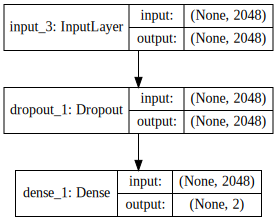

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [9]:
weights = model.get_weights()[0]

In [10]:
cnn_model = ResNet50(include_top=False, input_shape=(width, width, 3), weights='imagenet')
cnn_model = Model(cnn_model.input, cnn_model.layers[-2].output, name='resnet50')

inputs = Input((width, width, 3))
x = inputs
x = cnn_model(x)
cam = Conv2D(2, 1, use_bias=False, name='cam')(x)
model_cam = Model(inputs, cam)

x = GlobalAveragePooling2D(name='gap')(x)
x = model(x)
model_clf = Model(inputs, x)

In [11]:
model_cam.layers[-1].set_weights([weights.reshape((1, 1, 2048, 2))])

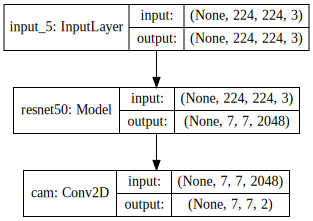

In [12]:
SVG(model_to_dot(model_cam, show_shapes=True).create(prog='dot', format='svg'))

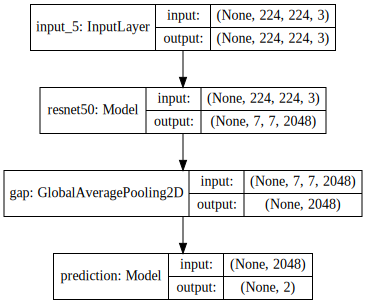

In [13]:
SVG(model_to_dot(model_clf, show_shapes=True).create(prog='dot', format='svg'))

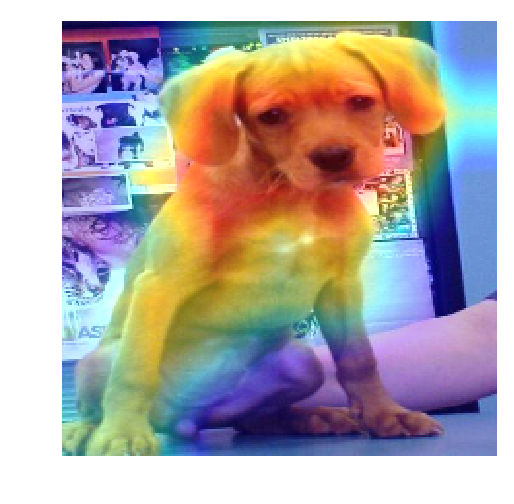

In [14]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 用模型进行预测
index = 13734
img = X[index]
prediction = model_clf.predict(np.expand_dims(img, 0))
prediction = prediction[0, 0]

cam = model_cam.predict(np.expand_dims(img, 0))
cam = cam[0, :, :, 1 if prediction < 0.5 else 0]

# 调整 CAM 的范围
cam /= 10
cam[cam < 0] = 0
cam[cam > 1] = 1
cam = cv2.resize(cam, (224, 224))
cam = np.uint8(255*cam)

# 染成彩色
heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

# 加在原图上
out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

# 显示图片
plt.axis('off')
plt.imshow(out[:,:,::-1])

In [15]:
model_clf.save('model_clf.h5')
model_cam.save('model_cam.h5')

In [16]:
from coremltools.converters.keras import convert

In [17]:
coreml_model = convert('model_clf.h5', blue_bias=103.939, green_bias=116.779, red_bias=123.68, 
                       input_names=['image'], image_input_names='image', output_names='prediction')

coreml_model.author = 'YPW'
coreml_model.short_description = 'Dogs vs Cats'
coreml_model.license = 'MIT'
coreml_model.input_description['image'] = 'A 224x224 Image.'
coreml_model.output_description['prediction'] = 'The probability of Dog and Cat.'
coreml_model.save('model_clf.mlmodel')

/usr/local/lib/python2.7/dist-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


0 : input_5, <keras.engine.topology.InputLayer object at 0x7f22701bc2d0>
1 : resnet50_conv1, <keras.layers.convolutional.Conv2D object at 0x7f22701bc410>
2 : resnet50_bn_conv1, <keras.layers.normalization.BatchNormalization object at 0x7f22701bc590>
3 : resnet50_activation_50, <keras.layers.core.Activation object at 0x7f22701bc850>
4 : resnet50_max_pooling2d_2, <keras.layers.pooling.MaxPooling2D object at 0x7f22701bca10>
5 : resnet50_res2a_branch2a, <keras.layers.convolutional.Conv2D object at 0x7f22701bca90>
6 : resnet50_bn2a_branch2a, <keras.layers.normalization.BatchNormalization object at 0x7f22701bcad0>
7 : resnet50_activation_51, <keras.layers.core.Activation object at 0x7f22701bcbd0>
8 : resnet50_res2a_branch2b, <keras.layers.convolutional.Conv2D object at 0x7f22701bcd10>
9 : resnet50_bn2a_branch2b, <keras.layers.normalization.BatchNormalization object at 0x7f22701bcd50>
10 : resnet50_activation_52, <keras.layers.core.Activation object at 0x7f22701bce50>
11 : resnet50_res2a_bran

93 : resnet50_activation_75, <keras.layers.core.Activation object at 0x7f227016b1d0>
94 : resnet50_res4b_branch2b, <keras.layers.convolutional.Conv2D object at 0x7f227016b310>
95 : resnet50_bn4b_branch2b, <keras.layers.normalization.BatchNormalization object at 0x7f227016b350>
96 : resnet50_activation_76, <keras.layers.core.Activation object at 0x7f227016b450>
97 : resnet50_res4b_branch2c, <keras.layers.convolutional.Conv2D object at 0x7f227016b590>
98 : resnet50_bn4b_branch2c, <keras.layers.normalization.BatchNormalization object at 0x7f227016b5d0>
99 : resnet50_add_25, <keras.layers.merge.Add object at 0x7f227016b6d0>
100 : resnet50_activation_77, <keras.layers.core.Activation object at 0x7f227016b810>
101 : resnet50_res4c_branch2a, <keras.layers.convolutional.Conv2D object at 0x7f227016b850>
102 : resnet50_bn4c_branch2a, <keras.layers.normalization.BatchNormalization object at 0x7f227016b890>
103 : resnet50_activation_78, <keras.layers.core.Activation object at 0x7f227016b990>
104 :

In [18]:
coreml_model = convert('model_cam.h5', blue_bias=103.939, green_bias=116.779, red_bias=123.68, 
                       input_names=['image'], image_input_names='image', output_names='cam')

coreml_model.author = 'YPW'
coreml_model.short_description = 'Dogs vs Cats'
coreml_model.license = 'MIT'
coreml_model.input_description['image'] = 'A 224x224 Image.'
coreml_model.output_description['cam'] = 'The cam Image.'
coreml_model.save('model_cam.mlmodel')

0 : input_5, <keras.engine.topology.InputLayer object at 0x7f2268070390>
1 : resnet50_conv1, <keras.layers.convolutional.Conv2D object at 0x7f22680704d0>
2 : resnet50_bn_conv1, <keras.layers.normalization.BatchNormalization object at 0x7f2268070650>
3 : resnet50_activation_50, <keras.layers.core.Activation object at 0x7f2268070910>
4 : resnet50_max_pooling2d_2, <keras.layers.pooling.MaxPooling2D object at 0x7f2268070b50>
5 : resnet50_res2a_branch2a, <keras.layers.convolutional.Conv2D object at 0x7f2268070bd0>
6 : resnet50_bn2a_branch2a, <keras.layers.normalization.BatchNormalization object at 0x7f2268070c10>
7 : resnet50_activation_51, <keras.layers.core.Activation object at 0x7f2268070d10>
8 : resnet50_res2a_branch2b, <keras.layers.convolutional.Conv2D object at 0x7f2268070e50>
9 : resnet50_bn2a_branch2b, <keras.layers.normalization.BatchNormalization object at 0x7f2268070e90>
10 : resnet50_activation_52, <keras.layers.core.Activation object at 0x7f2268070f90>
11 : resnet50_res2a_bran

92 : resnet50_bn4b_branch2a, <keras.layers.normalization.BatchNormalization object at 0x7f22684a5210>
93 : resnet50_activation_75, <keras.layers.core.Activation object at 0x7f22684a5310>
94 : resnet50_res4b_branch2b, <keras.layers.convolutional.Conv2D object at 0x7f22684a5450>
95 : resnet50_bn4b_branch2b, <keras.layers.normalization.BatchNormalization object at 0x7f22684a5490>
96 : resnet50_activation_76, <keras.layers.core.Activation object at 0x7f22684a5590>
97 : resnet50_res4b_branch2c, <keras.layers.convolutional.Conv2D object at 0x7f22684a56d0>
98 : resnet50_bn4b_branch2c, <keras.layers.normalization.BatchNormalization object at 0x7f22684a5710>
99 : resnet50_add_25, <keras.layers.merge.Add object at 0x7f22684a5810>
100 : resnet50_activation_77, <keras.layers.core.Activation object at 0x7f22684a5950>
101 : resnet50_res4c_branch2a, <keras.layers.convolutional.Conv2D object at 0x7f22684a5990>
102 : resnet50_bn4c_branch2a, <keras.layers.normalization.BatchNormalization object at 0x7f2